# Imports

In [1]:
! pip install ultralytics
! pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 13.7 MB/s eta 0:00:00


In [2]:
import pycocotools
from ultralytics import YOLO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import yaml
import torch
import shutil
import wandb

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset Splitting

In [3]:
train_imgs_dir="/kaggle/input/car-object-detection/data/training_images"
train_labels="/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv"

test_imgs_dir="/kaggle/input/car-object-detection/data/testing_images"

In [ ]:
imgs_list=list(sorted(os.listdir(train_imgs_dir)))
idxs=list(range(len(imgs_list)))
np.random.shuffle(idxs)

train_idx=idxs[:int(0.8*len(idxs))]
val_idx=idxs[int(0.8*len(idxs)):]

# Custom Dataset to Yolo Format

The Ultralytics YOLO format is a dataset configuration format that allows you to define the dataset root directory, the relative paths to training/validation/testing image directories or *.txt files containing image paths, and a dictionary of class names.

In [ ]:
#yolo dataset format 

# root directory
!mkdir "/kaggle/working/data"

# images directory 
!mkdir "/kaggle/working/data/images"

# train and test subdirectories with image directory
!mkdir "/kaggle/working/data/images/train"
!mkdir "/kaggle/working/data/images/val"

# labels directory
!mkdir "/kaggle/working/data/labels"

# train and test subdirectories with labels directory
!mkdir "/kaggle/working/data/labels/train"
!mkdir "/kaggle/working/data/labels/val"

In [ ]:
root_dir="/kaggle/working/data"
labels_dir="/kaggle/working/data/labels"
images_dir="/kaggle/working/data/images"

In [ ]:
df=pd.read_csv(train_labels)

width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

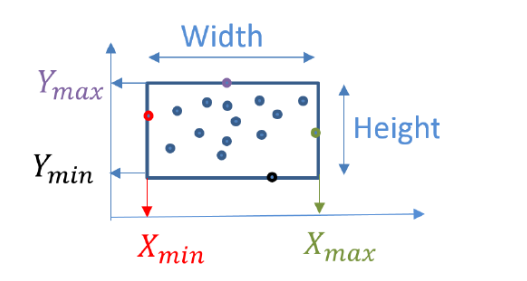


In [ ]:
df=pd.read_csv(train_labels)
print(df["xmin"].min())
print(df["xmax"].max())
print(df["ymin"].min())
print(df["ymax"].max())
df

In [ ]:
for idx,img_name in enumerate(imgs_list):
    subset="train"
    if idx in val_idx:
        subset="val"
        
    if np.isin(img_name,df_yolo["img_name"]):
        columns=["class","x_centre","y_centre","width","height"]
        img_bbox=df_yolo[df_yolo["img_name"]==img_name][columns].values
        
        label_file_path=os.path.join(labels_dir,subset,img_name[:-4]+".txt")
        with open(label_file_path,"w+") as f:
            for row in img_bbox:
                text=" ".join(row.astype(str))
                f.write(text)
                f.write("\n")
                
    old_image_path=os.path.join(train_imgs_dir,img_name)
    new_image_path=os.path.join(images_dir,subset,img_name)
    shutil.copy(old_image_path,new_image_path)

In [ ]:
yolo_format=dict(path="/kaggle/working/data",
                 train="/kaggle/working/data/images/train",
                 val="/kaggle/working/data/images/val",
                 nc=1,
                 names={0:"car"})
             
with open('/kaggle/working/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

# Wandb login

This is a required step for training, you can look at small tutorial for help
**[Weights & Biases Tutorial](https://www.kaggle.com/code/samuelcortinhas/weights-biases-tutorial-beginner)**

In [ ]:
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_secret = user_secrets.get_secret("wandb_api_key") 
wandb.login(key=my_secret)

# Training

In [ ]:
model = YOLO('yolov8m.pt')
for param in model.parameters():
    param.requires_grad = True


In [ ]:
"""Device is determined automatically. If a GPU is available then it will be used, 
   otherwise training will start on CPU."""

model.train(data="/kaggle/working/yolo.yaml",epochs=50,patience=5,batch=8,
                    lr0=0.0005,imgsz=640)

# Validate

In [ ]:
path_best_weights="/kaggle/working/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights) 

metrics = model.val() 

In [ ]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

# Prediction

In [ ]:
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.50,iou=0.75)

In [ ]:
# directory for saving predictions on test dataset
!mkdir "/kaggle/working/predictions"

In [ ]:
prediction_dir="/kaggle/working/predictions"

In [ ]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()
        
        test_img_list.append(name)
        
        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

# Prediction Visualization

In [ ]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    
    axis.imshow(img)
    axis.axis("off")

In [ ]:
fig,axes=plt.subplots(5,3,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,15)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_imgs_dir,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])
    
plt.savefig("1.png")